In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [25]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [26]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


<Axes: title={'center': 'PJME Energy'}, xlabel='Datetime'>

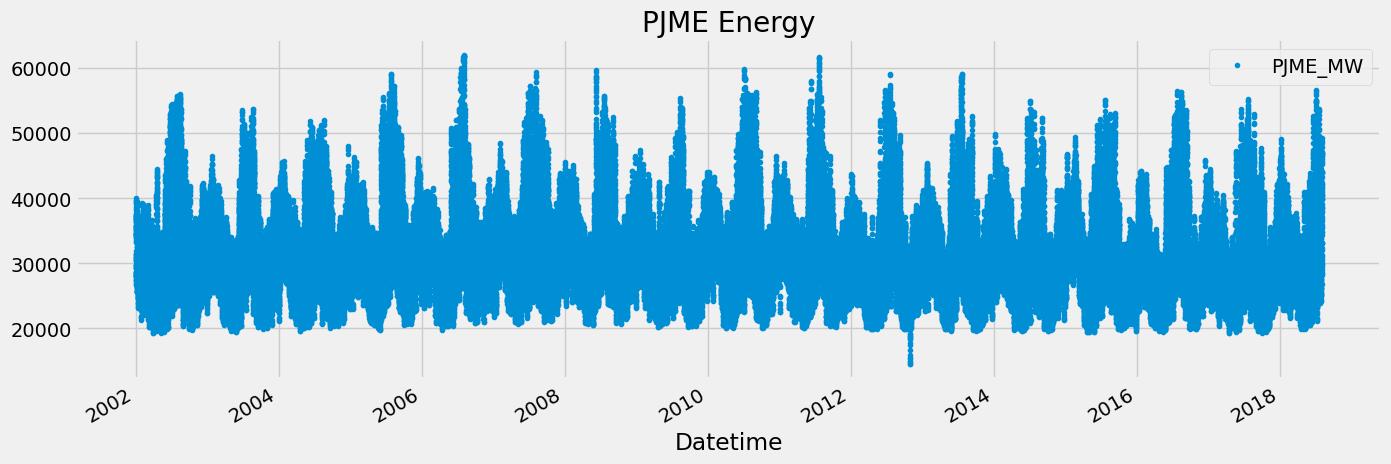

In [27]:
df.plot(style='.',
        figsize=(15,5),
        title='PJME Energy'
        )


<Axes: ylabel='Frequency'>

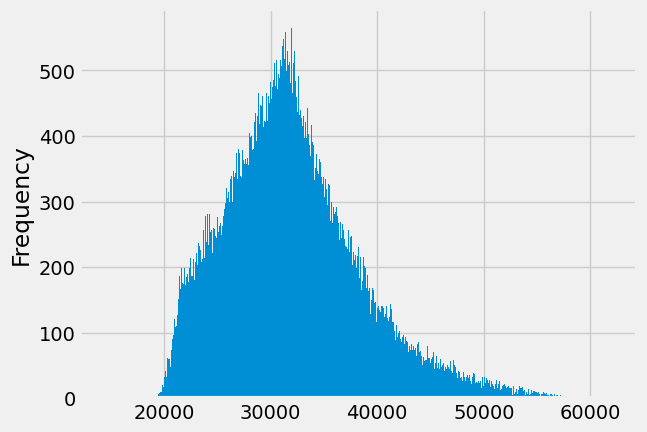

In [28]:
df['PJME_MW'].plot(kind='hist', bins=1000)


In [8]:
df

Index(['AEP_MW'], dtype='object')

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

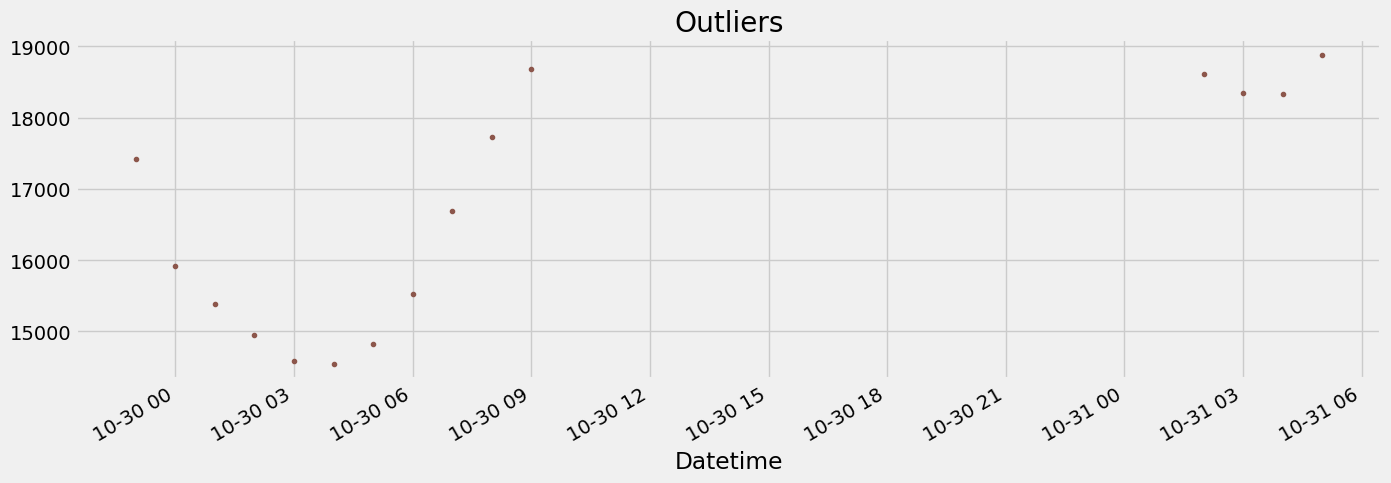

In [30]:
df.query('PJME_MW  < 19_000')['PJME_MW'].plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

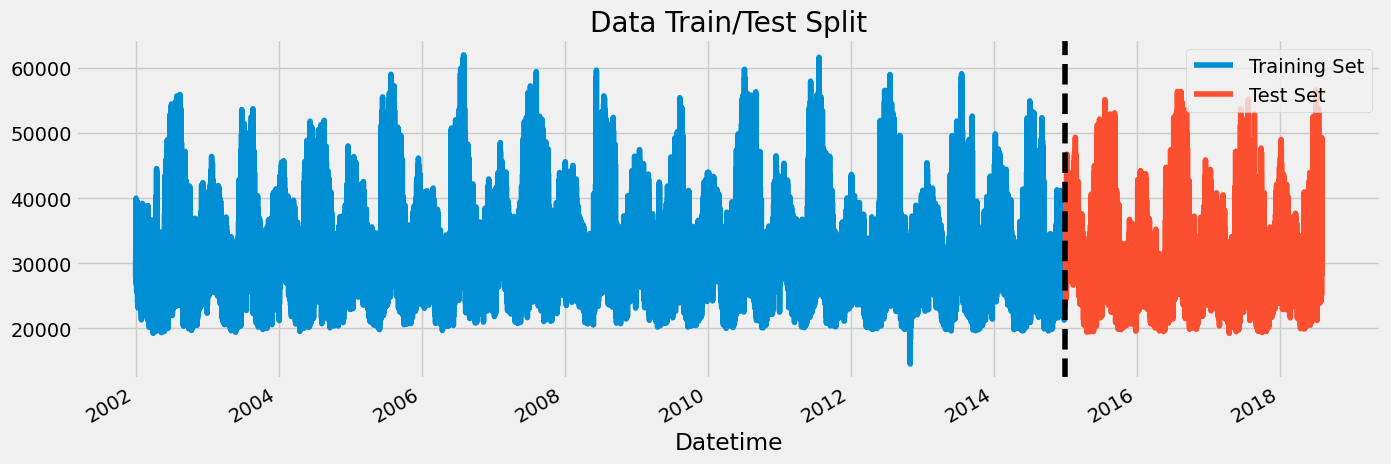

In [31]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [32]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

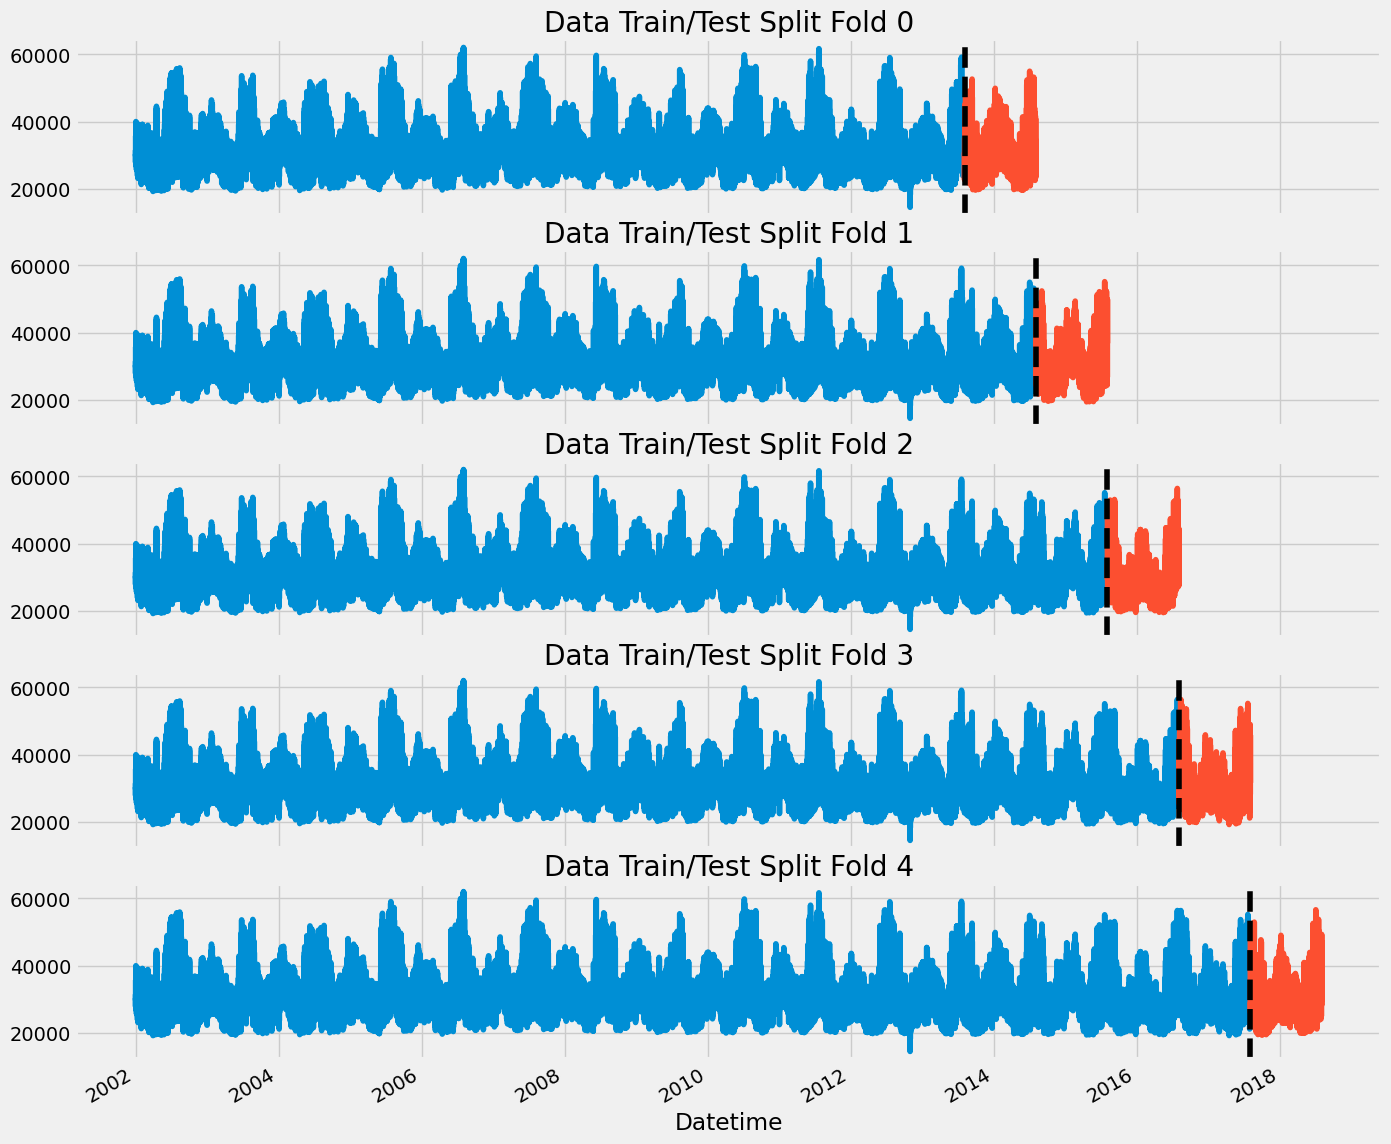

In [34]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1



In [35]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [36]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df


df = add_lags(df)

In [37]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0


In [38]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)  
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


[0]	validation_0-rmse:32730.70639	validation_1-rmse:31956.68992


c:\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [16:06:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.55336	validation_1-rmse:11909.41611
[200]	validation_0-rmse:5747.09818	validation_1-rmse:5364.37773
[300]	validation_0-rmse:3873.51430	validation_1-rmse:3899.82339
[400]	validation_0-rmse:3436.83821	validation_1-rmse:3761.31682
[471]	validation_0-rmse:3341.08977	validation_1-rmse:3765.71043
[0]	validation_0-rmse:32670.52224	validation_1-rmse:32138.89280


c:\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [16:06:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.49682	validation_1-rmse:12224.28419
[200]	validation_0-rmse:5757.00363	validation_1-rmse:5660.61027
[300]	validation_0-rmse:3906.64261	validation_1-rmse:3931.54029
[400]	validation_0-rmse:3480.55395	validation_1-rmse:3594.18390
[500]	validation_0-rmse:3356.18631	validation_1-rmse:3521.16813
[600]	validation_0-rmse:3300.89593	validation_1-rmse:3485.23578
[700]	validation_0-rmse:3261.72962	validation_1-rmse:3464.90388
[800]	validation_0-rmse:3225.50605	validation_1-rmse:3438.64983
[900]	validation_0-rmse:3197.54901	validation_1-rmse:3430.10289
[999]	validation_0-rmse:3171.60041	validation_1-rmse:3423.30152
[0]	validation_0-rmse:32629.68486	validation_1-rmse:31073.29137


c:\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [16:06:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12498.98688	validation_1-rmse:11138.63967
[200]	validation_0-rmse:5752.02891	validation_1-rmse:4816.91019
[300]	validation_0-rmse:3919.15626	validation_1-rmse:3552.07912
[399]	validation_0-rmse:3499.81175	validation_1-rmse:3491.88827
[0]	validation_0-rmse:32527.02577	validation_1-rmse:31475.38351


c:\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [16:06:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.05865	validation_1-rmse:12020.44091
[200]	validation_0-rmse:5737.80165	validation_1-rmse:5797.76066
[300]	validation_0-rmse:3915.35694	validation_1-rmse:4384.39516
[400]	validation_0-rmse:3498.63311	validation_1-rmse:4169.62998
[500]	validation_0-rmse:3383.05051	validation_1-rmse:4111.26353
[551]	validation_0-rmse:3349.92041	validation_1-rmse:4113.13413
[0]	validation_0-rmse:32460.74594	validation_1-rmse:31463.90740


c:\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [16:06:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.47503	validation_1-rmse:11959.11979
[200]	validation_0-rmse:5752.02184	validation_1-rmse:5613.55633
[300]	validation_0-rmse:3951.97347	validation_1-rmse:4156.62286
[400]	validation_0-rmse:3542.75274	validation_1-rmse:4008.30348
[436]	validation_0-rmse:3488.10069	validation_1-rmse:4006.43301


In [39]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3754.6872
Fold scores:[3758.5256000579657, 3423.147857410298, 3476.121686141068, 4111.027693505075, 4004.6130268714915]


In [40]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32402.66145


c:\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [16:07:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.65728
[200]	validation_0-rmse:5753.26464
[300]	validation_0-rmse:3973.71114
[400]	validation_0-rmse:3574.05442
[499]	validation_0-rmse:3459.67006


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [41]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [42]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [43]:
future_w_features = df_and_future.query('isFuture').copy()

In [46]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

<Axes: title={'center': 'Future Predictions'}>

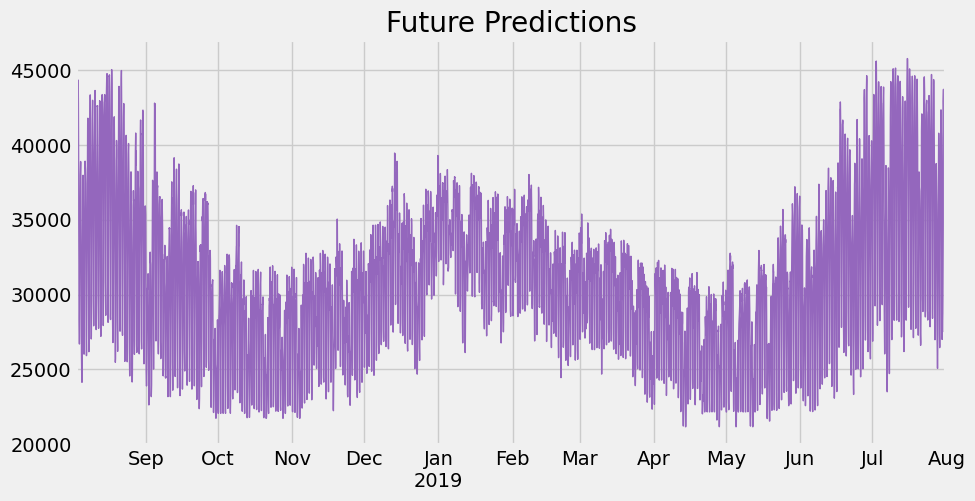

In [47]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')